In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from pandas import datetime
import tensorflow as tf
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
sns.set()

In [40]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import data_exploration as de
import store_data_cleaning as sdc
import train_data_cleaning as tdc
import preprocessing as pp
import lstm_prediction as lp
import split_dataset as spd
from plots import *

In [3]:
df_clean_train = pd.read_csv('../data/rossmann-store-sales/cleaned_train.csv')
df_clean_train.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,0,1,5,2015-07-31,5263,555,1,1,0,1
1,1,2,5,2015-07-31,6064,625,1,1,0,1
2,2,3,5,2015-07-31,8314,821,1,1,0,1
3,3,4,5,2015-07-31,13995,1498,1,1,0,1
4,4,5,5,2015-07-31,4822,559,1,1,0,1


In [52]:
df_clean_train = pd.read_csv('../data/rossmann-store-sales/test.csv')
df_clean_train.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### 1. Isolate the Rossmann Store Sales dataset into time series data

In [4]:
data_agg = df_clean_train.groupby("Date").agg({"Sales": "mean"})


In [5]:
preproc = pp.Preprocessing()
data_wo_outlier = preproc.handle_outliers(data_agg, "Sales", "")

In [6]:
data_wo_outlier_train = preproc.handle_outliers(df_clean_train, "Sales", "")
data_wo_outlier_train.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,0,1,5,2015-07-31,5263.0,555,1,1,0,1
1,1,2,5,2015-07-31,6064.0,625,1,1,0,1
2,2,3,5,2015-07-31,8314.0,821,1,1,0,1
3,3,4,5,2015-07-31,13611.5,1498,1,1,0,1
4,4,5,5,2015-07-31,4822.0,559,1,1,0,1


In [7]:
data_wo_outlier.describe()

,Sales
count,942.000000
mean,7220.057302
std,1659.939073
min,4067.142601
25%,5781.149180
50%,7055.626807
75%,8046.627604
max,11444.845240


### 2. Check whether your time Series Data is Stationary

<AxesSubplot:xlabel='Date'>

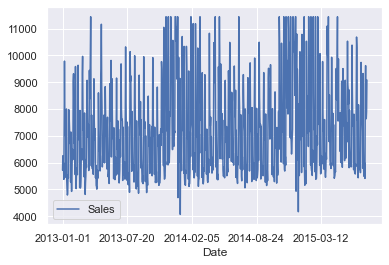

In [8]:
data_wo_outlier.plot()

<h3 style='font-style:italic'> Observation: Since we can observe seasonality on the graph, the data is not stationary.</h3>

### 3. Depending on your conclusion from 2 above difference your time series data

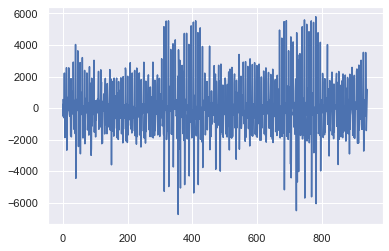

In [9]:
# performing difference transform (first order differencing)
df_agg_to_series = data_agg.copy()

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
 
series = pd.read_csv('../data/rossmann-store-sales/cleaned_train.csv', header=0, parse_dates=[3], index_col=0, squeeze=True, date_parser=parser)
data_agg_series = series.groupby("Date").agg({"Sales": "mean"})
preproc = pp.Preprocessing()
series = preproc.handle_outliers(data_agg_series, "Sales", "")
X = series.values
diff = difference(X)
plt.plot(diff)
plt.show()

### 4. Check for autocorrelation and partial autocorrelation of your data

#### Autocorrelation

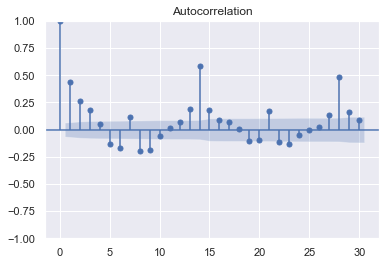

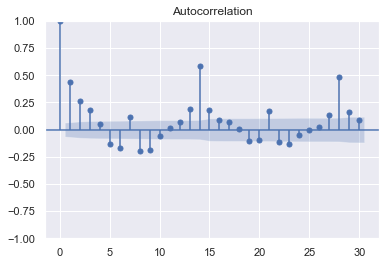

In [10]:
plot_acf(data_wo_outlier)

#### Partial Autocorrelation

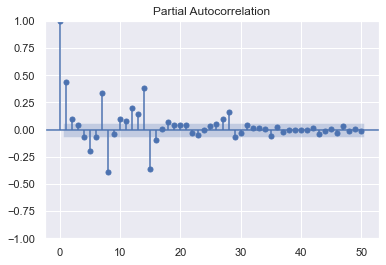

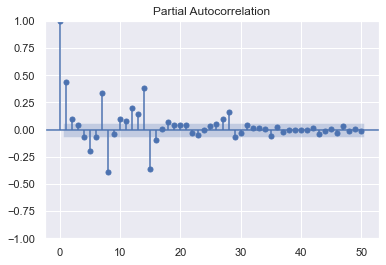

In [11]:
plot_pacf(data_wo_outlier, lags=50)

### 5. Transform the time series data into supervised learning data by creating a new y(target) column.

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Sales%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Sales%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Sales%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
    
diff_new  = diff.copy()
supervised_data = series_to_supervised(diff)
supervised_data['Sales'] = supervised_data['Sales1(t-1)']
supervised_data.drop(columns=['Sales1(t-1)'], inplace=True)
first_column = supervised_data.pop('Sales')
  
supervised_data.insert(0, 'Sales', first_column)
supervised_data.head()

,Sales,Sales1(t)
1,[535.7657648117747],[-531.5582116372143]
2,[-531.5582116372143],[267.92230454470064]
3,[267.92230454470064],[-615.5096334778036]
4,[-615.5096334778036],[2197.568630247706]
5,[2197.568630247706],[2215.298753212144]


### 6. Scale your data in the (-1, 1) range

In [46]:
nd = supervised_data.to_numpy()

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_data = scaler.fit_transform(nd)
scaled_df = pd.DataFrame(scaled_data, columns=supervised_data.columns)
scaled_df

,Sales,Sales1(t)
0,0.580939,0.495855
1,0.495855,0.559587
2,0.559587,0.489162
3,0.489162,0.713413
4,0.713413,0.714826
...,...,...
935,0.819071,0.592989
936,0.592989,0.424189
937,0.424189,0.494173
938,0.494173,0.559637


### 7. Build a LSTM Regression model to predict the next sale

In [62]:
SIZE = len(scaled_df["Sales"])
# SIZE = len(data_agg["Sales"])

WINDOW_SIZE = 24
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 100 
pred = lp.LstmPrediction(WINDOW_SIZE, BATCH_SIZE, scaled_df)

print(SIZE)
print(BATCH_SIZE)

940
892


2022/05/28 21:59:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_7 (LSTM)               (None, 10)                1240      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-05-28 21:59:29.139535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:59:29.445794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:59:29.541288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:59:29.635594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 2s 2s/step - loss: 0.0667

2022-05-28 21:59:29.722199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 0.0667 - val_loss: 0.0538
Epoch 2/100


2022-05-28 21:59:30.578426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:59:30.648482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:59:30.683863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 85ms/step - loss: 0.0556 - val_loss: 0.0435
Epoch 3/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0455 - val_loss: 0.0344
Epoch 4/100
1/1 [==============================] - 0s 76ms/step - loss: 0.0365 - val_loss: 0.0265
Epoch 5/100
1/1 [==============================] - 0s 81ms/step - loss: 0.0288 - val_loss: 0.0199
Epoch 6/100
1/1 [==============================] - 0s 75ms/step - loss: 0.0223 - val_loss: 0.0146
Epoch 7/100
1/1 [==============================] - 0s 75ms/step - loss: 0.0172 - val_loss: 0.0108
Epoch 8/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0136 - val_loss: 0.0084
Epoch 9/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0113 - val_loss: 0.0073
Epoch 10/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0105 - val_loss: 0.0075
Epoch 11/100
1/1 [==============================] - 0s 74ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 12/100
1/1 [============

2022/05/28 21:59:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


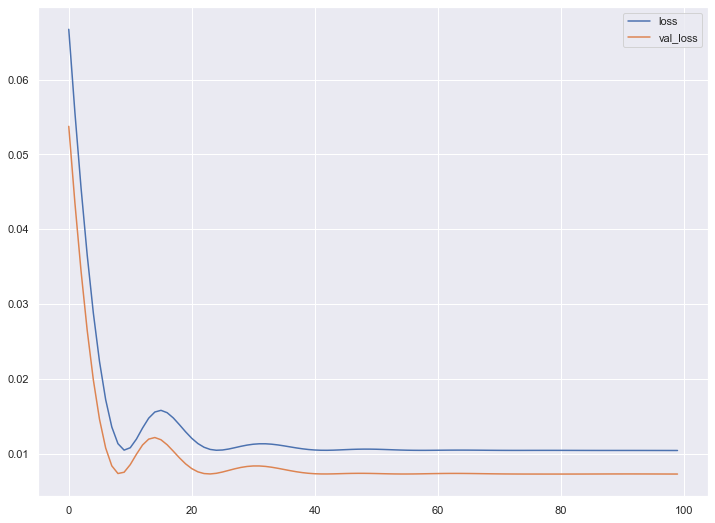

In [61]:
model1, his = pred.train(EPOCHS)

2022-05-28 21:58:34.666431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:58:34.788990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 21:58:34.834615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 474ms/step


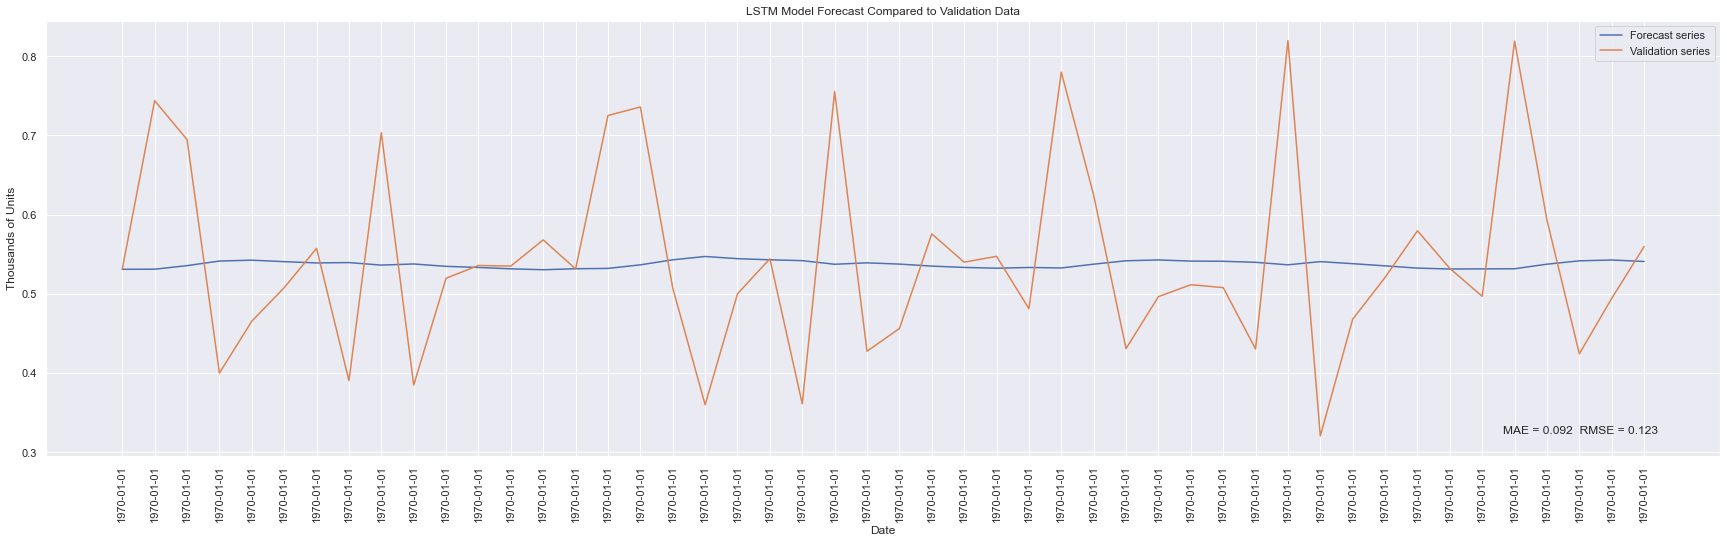

In [57]:
forecast, fig, MAE, RMSE = pred.model_forecast_test(model1)


#### Forcast the sales for the next 6 weeks

In [33]:

def forcast_next_one_sale(model, sales):
    data_feat = None
    WINDOW_SIZE = 49
    try:
        data_feat = sales[["Sales", "Date"]]
        
        if (data_feat.shape[0] < 49):
            print("To make prediction, we need atleast data of 49 dates")
            return
        scaled_dff, scaler_obj = lp.LstmPrediction(WINDOW_SIZE, BATCH_SIZE, scaled_df).add_scaled_sales(data_feat)
        data_feat["Sales"].isna().any().sum()
        SIZE = len(data_agg["Sales"])
        
        
        series = scaled_dff["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
        ds = ds.batch(SIZE).prefetch(1)
        
        forecast = model.predict(ds)
        Results = list(forecast.reshape(1, forecast.shape[0] * forecast.shape[1])[0].copy())

        Results1 = scaler_obj.inverse_transform(forecast.reshape(-1,1))
        Results1 = list(Results1.reshape(1, Results1.shape[0] * Results1.shape[1])[0])
        
        return  Results1, Results
        
    except KeyError as e:
        print(e)
        return False

In [34]:
def forcast_next_sales(model, sales, daysToForcast=1):
    forcasts = []
    scaled_forcasts = []
    dates = []
    
    new_sales_df = sales.copy()
    while len(forcasts) < daysToForcast:
        forcast, scaled_forcast = forcast_next_one_sale(model, new_sales_df)
        forcasts += forcast
        
        scaled_forcasts += scaled_forcast
        size=len(new_sales_df["Sales"])
        
        truncated_sales = new_sales_df.tail(size - len(scaled_forcast))
                
        new_sales = truncated_sales['Sales'].to_list() + scaled_forcast
        next_dates = []
        
        for i in range(len(scaled_forcast)):
            next_date = new_sales_df["Date"].to_list()[-1] + timedelta(days=1)
            next_dates.append(next_date)     
        
        new_dates = truncated_sales['Date'].to_list() + next_dates
        new_sales_df = pd.DataFrame()
        new_sales_df["Date"] = new_dates
        new_sales_df["Sales"] = new_sales
    
    res_df = pd.DataFrame()
    res_df["Date"] = new_dates
    res_df["forcasts"] = forcasts
    
    return res_df

In [51]:
dt_agg = data_agg.copy()
dt_agg.drop(dt_agg.tail(2).index,
        inplace = True)
scaled_df["Date"] = dt_agg.index
scaled_df["Date"] = scaled_df["Date"].astype("datetime64[ns]")
res_df = forcast_next_sales(model1, scaled_df.head(49), 49)
res_df

1/1 [==============================] - 0s 27ms/step


,Date,forcasts
0,2013-02-19,0.746619
1,2013-02-20,0.756161
2,2013-02-21,0.769778
3,2013-02-22,0.789436
4,2013-02-23,0.815733
5,2013-02-24,0.839748
6,2013-02-25,0.865111
7,2013-02-26,0.888466
8,2013-02-27,0.911094
9,2013-02-28,0.931935


In [45]:
sk_path_dir_2 = mlflow.sklearn.save_model(model1, "../models/lstm_model",
                          serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

INFO:tensorflow:Assets written to: ram://9b996260-8706-4831-9fdf-ca285dff0220/assets


INFO:tensorflow:Assets written to: ram://9b996260-8706-4831-9fdf-ca285dff0220/assets
